A network for detecting dominant instrument from the full spectogram of an audio file, trained on the IRMAS dataset. Unlike the others though, this network relies mostly on 1D convolutions which extend over the full array of frequency bins and keep each time step separate.

# Imports and macros

In [162]:
from IPython.display import Audio
import librosa
from librosa.display import specshow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import random
import time
import threading
from tqdm import tqdm

In [2]:
train_path = 'data/IRMAS-TrainingData'
test_path = 'data/IRMAS-TestingData-Part1/Part1'
NUM_CLASSES = 11
CLS_NAMES = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
fourier_window = 2048
sample_rate = 22050
segment_dur = 43
freq_bins = 1025

In [3]:
# Play random sample
sample_path = os.path.join(train_path, 'sax/118__[sax][nod][jaz_blu]1702__3.wav')
music_path = 'data/sax_10s.mp3'
Audio(sample_path)

# Utility Functions

In [49]:
def generate_spectogram(filename, segment_dur=43):
    # Load audio
    audio, sr = librosa.load(filename)
    # Perform Short-time Fourier Transform
    # 2048 is window size
    spec = librosa.stft(audio, fourier_window)
    # phases (which we don't use)
    # phases = np.angle(spec)
    # Magnitude
    if (spec.shape[1] >= segment_dur):
        idx = random.randint(0,spec.shape[1]-segment_dur)
        output = np.log1p(np.abs(spec[:,idx:idx+segment_dur]))
    else:
        output = np.log1p(np.abs(spec))
    # Returns matrix (frequency bin f, time t) and sample rate of source audio
    return output

In [4]:
def display_spectogram(spec, name):
    spec = np.squeeze(np.copy(spec))
    specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time')
    plt.title(name)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [8]:
spec = generate_spectogram(music_path)

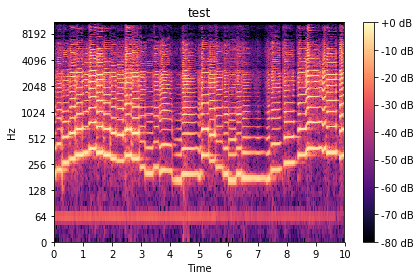

In [9]:
display_spectogram(spec, "test")

In [53]:
def data_generator(batch_size=1, seg_dur=43, train=True):
    
    segment_dur = seg_dur
    
    if (train == True):
        # Compile list of filenames
        files_dict = {}
        for cls in CLS_NAMES:
            folder_path = os.path.join(train_path, cls)
            files_dict[cls] = glob.glob(os.path.join(folder_path, "*.wav"))

        while(True):
            batch = np.empty((batch_size, segment_dur, freq_bins))
            gt = np.zeros((batch_size, NUM_CLASSES))
            for i in range(batch_size):
                # Put in spectogram of random file
                cls = random.choice(CLS_NAMES)
                file = random.choice(files_dict[cls])
                spec = generate_spectogram(file, segment_dur)
                while (spec.shape[1] < segment_dur):
                    cls = random.choice(CLS_NAMES)
                    file = random.choice(files_dict[cls])
                    spec = generate_spectogram(file, segment_dur)
                batch[i, :, :] = spec.T
                gt[i, CLS_NAMES.index(cls)] = 1.0
            yield batch, gt
    
    else:
        # Compile list of test filenames
        files = []
        files = glob.glob(os.path.join(test_path, "*.wav"))
        
        while(True):
            batch = np.empty((batch_size, segment_dur, freq_bins))
            batch_files = []
            for i in range(batch_size):
                # Put in spectogram of random file
                file = random.choice(files)
                spec = generate_spectogram(file, segment_dur)
                while (spec.shape[1] < segment_dur):
                    file = random.choice(files)
                    spec = generate_spectogram(file, segment_dur)
                batch_files.append(file)
                batch[i, :, :] = spec.T
            yield batch, batch_files

In [6]:
def interpret_prediction(index):
    index = np.array(index) 
    preds = []
    for id in index:
        preds.append(CLS_NAMES[id])
    return preds

In [104]:
def class_from_index(index):
    
    return CLS_NAMES[index]

In [7]:
def interpret_gt(gt):
    
    gt = np.squeeze(np.argmax(gt, axis=1))
    
    try:
        return CLS_NAMES[gt]
    except:
        answers = []
        for id in gt:
            answers.append(CLS_NAMES[id])
        return answers
        

In [166]:
# Prepare test dictionary    
test_dict = {}
files = []
files = glob.glob(os.path.join(test_path, "*.wav"))

for file in tqdm(files):
    test_dict[file] = np.zeros((NUM_CLASSES))
    name = file[:-3]
    name += 'txt'
    with open(name, 'r') as myfile:
        data=myfile.read().replace('\n', '')
    data = data.split()
    for cls in data:
        idx = CLS_NAMES.index(cls)
        test_dict[file][idx] = 1

100%|██████████| 807/807 [00:00<00:00, 28489.69it/s]


# Construct model

In [9]:
# def selu(x):
#     with ops.name_scope('elu') as scope:
#         alpha = 1.6732632423543772848170429916717
#         scale = 1.0507009873554804934193349852946
#         return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

In [187]:
def conv_layer(layer_input, input_fsize, output_fsize, name):
        
    w = tf.get_variable(name+"_w", shape=[1, input_fsize, output_fsize], 
                        initializer=tf.contrib.layers.xavier_initializer(), 
                        regularizer=tf.contrib.layers.l2_regularizer(.16))
    b = tf.Variable(tf.constant(0.0, shape=[output_fsize]), name=name+"_b")
    layer = tf.nn.elu(tf.add(tf.nn.conv1d(layer_input, w, 1, padding='VALID'), b), name=name)
    return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=True)

In [188]:
def avg_pool(X, name, pool_size=2):
    
    return tf.layers.average_pooling1d(X, pool_size, strides=(pool_size,), name=name)

In [189]:
def construct_model(X, in_size, keep_prob=1.0):
    
    conv1 = conv_layer(X, in_size, 1024, "conv1")
    conv2 = conv_layer(conv1, 1024, 1024, "conv2")
    conv3 = conv_layer(conv2, 1024, 512, "conv3")
    conv4 = conv_layer(conv3, 512, 512, "conv4")
    drop1 = tf.nn.dropout(conv4, keep_prob)
    pool1 = avg_pool(conv4, "pool1")
    conv5 = conv_layer(pool1, 512, 256, "conv5")
    conv6 = conv_layer(conv5, 256, 256, "conv6")
    drop2 = tf.nn.dropout(conv6, keep_prob)
    pool2 = avg_pool(conv6, "pool2")
    conv7 = conv_layer(pool2, 256, NUM_CLASSES, "conv7")
    drop3 = tf.nn.dropout(conv7, keep_prob)
    logits = tf.squeeze(tf.reduce_mean(conv7, axis=1, name="logits"))
    return logits

In [203]:
class model:
    
    def __init__(self, in_size=freq_bins, filter_size=3, pool_size=2):
                
        # Build model
        # Placeholders
        self.X = tf.placeholder(tf.float32, shape=None, name="input")
        self.y = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name="gt")
        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        
        self.logits = construct_model(self.X, in_size, keep_prob=self.keep_prob)
        
        self.loss = self.get_loss(self.logits)
        
        self.soft = tf.nn.softmax(self.logits)
        self.result = tf.argmax(tf.squeeze(self.soft), axis=-1)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.result, tf.argmax(tf.squeeze(self.y), axis=-1)), tf.float32))
    
    def get_loss(self, logits):
        
        loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.y))
        
        self.reg_loss = sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        loss += self.reg_loss
        
        return loss
    
    def save(self, sess, model_path):
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
    
    def predict(self, spec, gt, model_path=None, restore=True):
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            
            if restore:
                self.restore(sess, model_path)
            
            accuracy = sess.run([self.accuracy], feed_dict={self.X: spec, 
                                                            self.y: gt,
                                                            self.keep_prob: 1.0})
        
        return accuracy
    
    def evaluate(self, data_gen, sess, iters=10, seg_dur=43):
        # Use five seconds of the longer eval songs
        segment_dur = seg_dur
            
        acc = 0.0
        batch_size = 1
        for i in range(iters):

            batch, batch_files = next(data_gen)
            batch_size = len(batch_files)
            prediction = sess.run([self.result], feed_dict={self.X: batch, self.keep_prob: 1.0})
            for i,file in enumerate(batch_files):
                idx = prediction[0][i]
                if (test_dict[file][idx] > 0):
                    acc += 1.0

        acc /= (iters*batch_size)
        
        # Reset segment duration to 43 for more training
        segment_dur = 43
        
        return acc
    
    def train(self, data_gen, model_path, val_gen=None, val_dur=43, iters=10, learning_rate=1e-3, display=1, restore=False, keep_prob=0.5):
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        
        startTime = time.time()
        
        with tf.Session() as sess:
            
            print("Starting training")
            
            sess.run(init)
        
            if restore:
                self.restore(sess, model_path)
            
            total_acc = 0.0
            total_loss = 0.0
            
            best_acc = 0.5
            
            save_path = model_path
            
            for step in range(iters):
                
                batch, gt = next(data_gen)
                
                _, loss, acc = sess.run((self.optimizer, self.loss, self.accuracy),
                                                    feed_dict={self.X: batch,
                                                              self.y: gt,
                                                              self.keep_prob: keep_prob})
                
                total_loss += loss
                total_acc += acc
                
                if (step+1) % display == 0:
                    
                    print("At iteration {} training loss equals {} and accuracy equals {}".format(step+1, total_loss/(display), total_acc/(display)))
                    if (val_gen != None):
                        val_acc = self.evaluate(val_gen, sess, iters=16, seg_dur=val_dur)
                        print("And validation accuracy equals {}".format(val_acc))
                        if (val_acc > best_acc):
                            save_path = self.save(sess, model_path)
                            best_acc = val_acc
                            print("model saved")
                    else:
                        if (total_acc/display > best_acc):
                            save_path = self.save(sess, model_path)
                            best_acc = total_acc/display
                            print("model saved")
                    
                    total_loss = 0.0
                    total_acc = 0.0
                    
            print("TRAINING FINISHED")
            
            print("Time taken: %f" % (time.time() - startTime))
                    
        return save_path
        

# Train model

In [204]:
tf.reset_default_graph()

In [205]:
# instr_id is at 40-something accuracy and id_fullspec is currently at 40
model_path = 'model/instr_id_1d_reg.ckpt'
segment_dur = 43
data_gen = data_generator(batch_size=24, seg_dur=segment_dur)
val_gen = data_generator(batch_size=24, seg_dur=43, train=False)

In [206]:
my_model = model()

In [207]:
model_path = my_model.train(data_gen, model_path, val_gen=val_gen, 
                            val_dur=43,iters=50000, 
                            learning_rate=1e-4, display=200,
                            restore=True)

Starting training
INFO:tensorflow:Restoring parameters from model/instr_id_1d_reg.ckpt
At iteration 200 training loss equals 39.4443976688385 and accuracy equals 0.627500019967556
And validation accuracy equals 0.4010416666666667
At iteration 400 training loss equals 38.96155627250671 and accuracy equals 0.6218750187754631
And validation accuracy equals 0.4375
At iteration 600 training loss equals 37.44522615432739 and accuracy equals 0.6341666863858699
And validation accuracy equals 0.4713541666666667
At iteration 800 training loss equals 36.82216195106506 and accuracy equals 0.6489583504199982
And validation accuracy equals 0.4375
At iteration 1000 training loss equals 37.06901347160339 and accuracy equals 0.6452083532512188
And validation accuracy equals 0.4609375
At iteration 1200 training loss equals 36.37057291984558 and accuracy equals 0.6497916854918003
And validation accuracy equals 0.4244791666666667


KeyboardInterrupt: 

# Test model

In [46]:
tf.reset_default_graph()

In [47]:
my_model = model()

In [48]:
data_gen = data_generator(batch_size=4, train=False)

In [49]:
batch, batch_files = next(data_gen)

In [50]:
result = my_model.predict(spec=batch, model_path=model_path, restore=True)

INFO:tensorflow:Restoring parameters from model/instr_id_1d.ckpt


In [51]:
interpret_prediction(result)

['cla', 'pia', 'sax', 'gel']

In [52]:
print(batch_files)

['data/IRMAS-TestingData-Part1/Part1/01 - roads-8.wav', 'data/IRMAS-TestingData-Part1/Part1/01. In The Crease-20.wav', 'data/IRMAS-TestingData-Part1/Part1/01 Blue Train-5.wav', 'data/IRMAS-TestingData-Part1/Part1/01) Jeff Beck - Hi-Ho Silver Lining-4.wav']


In [69]:
Audio(batch_files[0])

In [53]:
for file in batch_files:
    name = file[:-3]
    name += 'txt'
    with open(name, 'r') as myfile:
        data=myfile.read().replace('\n', '')
    data = data.split()
    
    print(data)

['voi']
['pia', 'sax']
['pia', 'sax']
['gel', 'vio', 'voi']


# Evaluate model

In [118]:
tf.reset_default_graph()

In [119]:
model_path = 'model/instr_id_1d.ckpt'
segment_dur = 43

In [120]:
my_model = model()

In [121]:
data_gen = data_generator(batch_size=5, seg_dur=segment_dur, train=False)

In [122]:
acc = my_model.evaluate(data_gen, model_path, seg_dur=segment_dur, iters=5)

INFO:tensorflow:Restoring parameters from model/instr_id_1d.ckpt


In [123]:
print(acc)

0.36


In [69]:
def evaluate(data_gen, check_num):
    acc = 0.0
    for i in range(check_num):
        
        batch_acc = 0.0
        batch, batch_files = next(data_gen)
        result = my_model.predict(spec=batch, model_path=model_path, restore=True)
        result = interpret_prediction(result)
        for i,file in enumerate(batch_files):
            name = file[:-3]
            name += 'txt'
            with open(name, 'r') as myfile:
                data=myfile.read().replace('\n', '')
            data = data.split()
            if (result[i] in data):
                batch_acc += 1.0
        batch_acc /= len(batch_files)
        acc += batch_acc
    
    acc /= check_num
    print("###############")
    print(acc)
    print("###############")

In [70]:
evaluate(data_gen, 30)

INFO:tensorflow:Restoring parameters from model/instr_id_1d.ckpt


TypeError: Cannot cast ufunc add output from dtype('<U32') to dtype('float64') with casting rule 'same_kind'